In [628]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import scipy.stats as stats
import bspline
import bspline.splinelab as splinelab
import time

In [629]:
mu = 0.35     # drift
r = 0.124      # risk-free rate
T = 4
M = 1         # maturity
N_MC = 1000    # number of paths
delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor
# Define the risk aversion parameter
risk_lambda = 0.0008 # risk aversion parameter
reg_param = 1e-3

S0 = 223.80      # initial stock price
K = 69.73
sigma = 1.44  # volatility


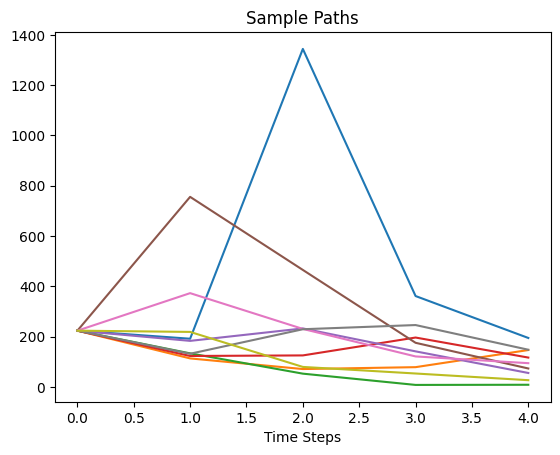

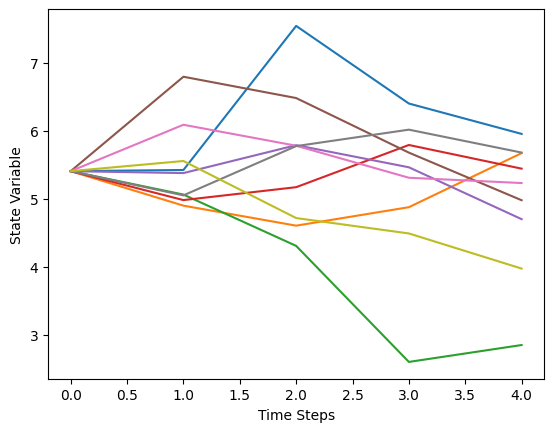

In [630]:
S = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S.loc[:,0] = S0


# standard normal random numbers
RN = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1))

for t in range(1, T+1):
    S.loc[:,t] = S.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:,t])

delta_S = S.loc[:,1:T].values - np.exp(r * delta_t) * S.loc[:,0:T-1]
delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)


# state variable
X = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S.astype(float) / 1.0)  # delta_t here is due to their conventions

# plot 10 paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(S.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Sample Paths')
plt.show()

plt.plot(X.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('State Variable');

X.shape =  (1000, 5)
X_min, X_max =  0.5467296098349284 9.774280693595356
Number of points k =  17


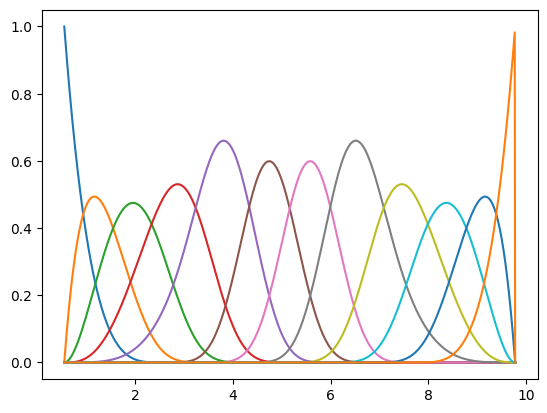

<Figure size 640x480 with 0 Axes>

In [631]:
"""## **Define spline basis functions**"""

X_min = np.min(np.min(X))
X_max = np.max(np.max(X))

print('X.shape = ', X.shape)
print('X_min, X_max = ', X_min, X_max)

p = 4 # order of spline (as-is; 3: cubic, 4: B-spline?)
ncolloc = 12

tau = np.linspace(X_min, X_max, ncolloc)  # These are the sites to which we would like to interpolate

# k is a knot vector that adds endpoints repeats as appropriate for a spline of order p
# To get meaninful results, one should have ncolloc >= p+1
k = splinelab.aptknt(tau, p)

# Spline basis of order p on knots k
basis = bspline.Bspline(k, p)
f = plt.figure()

print('Number of points k = ', len(k))
basis.plot()

plt.savefig('Basis_functions.png', dpi=600)



In [632]:
"""## **Make data matrices with feature values**"""

num_t_steps = T + 1
num_basis =  ncolloc

data_mat_t = np.zeros((num_t_steps, N_MC,num_basis ))
# data_mat_t_1 = np.zeros((num_t_steps, N_MC,num_basis ))

print('num_basis = ', num_basis)
print('dim data_mat_t = ', data_mat_t.shape)

t_0 = time.time()

# fill it
for i in np.arange(num_t_steps):
    x = X.values[:,i]
    # x_1 = X_1.values[:,i]
    data_mat_t[i,:,:] = np.array([ basis(i) for i in x ])
    # data_mat_t_1[i,:,:] = np.array([ basis(i) for i in x_1 ])

t_end = time.time()
print('Computational time:', t_end - t_0, 'seconds')

# save these data matrices for future re-use
np.save('data_mat_m=r_A_%d' % N_MC, data_mat_t)
# np.save('data_mat_m=r_B_%d' % N_MC, data_mat_t_1)

print(data_mat_t.shape) # shape: num_steps x N_MC x num_basis
print(len(k))

num_basis =  12
dim data_mat_t =  (5, 1000, 12)
Computational time: 0.246870756149292 seconds
(5, 1000, 12)
17


In [633]:
def terminal_payoff(ST, K):
    # ST   final stock price    # K    strike
    payoff = max(K - ST, 0)
    return payoff

# functions to compute optimal hedges
def function_A_vec(t,delta_S_hat,data_mat_t,reg_param):
    # Compute the matrix A_{nm} from Eq. (52) (with a regularization!)
    X_mat = data_mat_t[t,:,:]
    num_basis_funcs = X_mat.shape[1]
    this_dS = delta_S_hat.loc[:,t].values
    hat_dS2 = (this_dS**2).reshape(-1,1)    
    A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs)
    return A_mat
        
def function_B_vec(t, Pi_hat, delta_S=delta_S, delta_S_hat=delta_S_hat, S=S, data_mat_t=data_mat_t,
                  gamma=gamma,risk_lambda=risk_lambda):
    coef = 1.0/(2 * gamma * risk_lambda)
    tmp =  Pi_hat.loc[:,t+1] * delta_S_hat.loc[:,t] + coef * (np.exp(mu*delta_t) - np.exp(r*delta_t))* S.loc[:,t]
    X_mat = data_mat_t[t,:,:]  # matrix of dimension N_MC x num_basis
    
    B = np.dot(X_mat.T, tmp)    
    return B

def function_C_vec(t,data_mat_t,reg_param):
    # Compute the matrix A_{nm} from Eq. (52) (with a regularization!)
    X_mat = data_mat_t[t,:,:]
    num_basis_funcs = X_mat.shape[1]    
    C_mat = np.dot(X_mat.T, X_mat) + reg_param * np.eye(num_basis_funcs)
    return C_mat

def function_D_vec(t, Q, R, data_mat_t, gamma=gamma):
    X_mat = data_mat_t[t,:,:]
    tmp = R.loc[:,t] + gamma * Q.loc[:,t+1]  # note that the second argument in Q is t+1 !
    D = np.dot(X_mat.T, tmp.values)
    return D

a: 
             0         1         2         3  4
1     0.19254  0.144138  0.081102  0.165326  0
2     0.19254  0.321616  0.677419  0.340693  0
3     0.19254  0.312141  0.571842  0.592044  0
4     0.19254  0.330132  0.494808  0.417202  0
5     0.19254  0.296263  0.595358  0.366036  0
...       ...       ...       ...       ... ..
996   0.19254  0.288975  0.419452  0.456096  0
997   0.19254  0.099555   0.19102  0.066615  0
998   0.19254  0.302534  0.495771  0.595321  0
999   0.19254  0.279075  0.624789  0.252886  0
1000  0.19254  0.302226  0.216497  0.223876  0

[1000 rows x 5 columns]
phi: 
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.50439006e-03 1.33058310e-01 2.55509853e-01 5.20085096e-02
 1.06839405e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00]


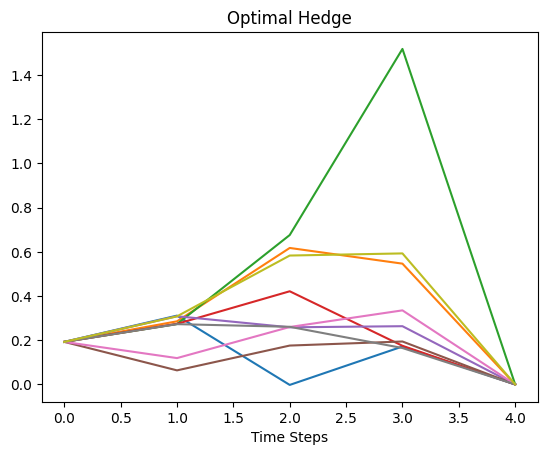

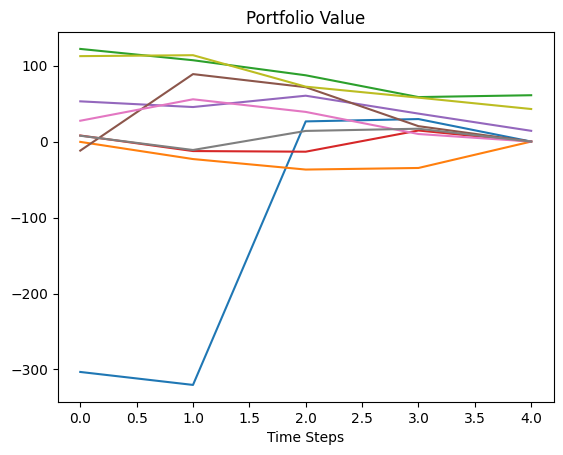

In [634]:
# portfolio value
Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))

Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_hat.iloc[:,-1] = Pi.iloc[:,-1] - np.mean(Pi.iloc[:,-1])

# optimal hedge
a = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a.iloc[:,-1] = 0


reg_param = 1e-3

for t in range(T-1, -1, -1):

    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat)

    # Convert A_mat and B_vec to a NumPy array of floats
    A_mat = np.array(A_mat, dtype=float)
    B_vec = np.array(B_vec, dtype=float)

    phi = np.dot(np.linalg.inv(A_mat), B_vec)

    a.loc[:,t] = np.dot(data_mat_t[t,:,:],phi)
    Pi.loc[:,t] = gamma * (Pi.loc[:,t+1] - a.loc[:,t] * delta_S.loc[:,t])
    Pi_hat.loc[:,t] = Pi.loc[:,t] - np.mean(Pi.loc[:,t])

print("a: \n", a)
print ("phi: \n", phi)
a = a.astype('float')
Pi = Pi.astype('float')
Pi_hat = Pi_hat.astype('float')


# plot 10 paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(a.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Optimal Hedge')
plt.show()

plt.plot(Pi.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Portfolio Value');

In [635]:
# The Black-Scholes prices
def bs_put(t, S0=S0, K=K, r=r, sigma=sigma, T=M):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = K * np.exp(-r * (T-t)) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return price

def bs_call(t, S0=S0, K=K, r=r, sigma=sigma, T=M):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = S0 * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)
    return price

In [636]:
# disturbance level eta: Each action is multiplied by a uniform r.v. in the interval [1-eta, 1 + eta]
eta = 0.1
reg_param = 1e-3

a_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_op.iloc[:,-1] = 0

# also make portfolios and rewards
# portfolio value
Pi_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_op.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))

Pi_op_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_op_hat.iloc[:,-1] = Pi_op.iloc[:,-1] - np.mean(Pi_op.iloc[:,-1])

# reward function
R_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
R_op.iloc[:,-1] = - risk_lambda * np.var(Pi_op.iloc[:,-1])

# The backward loop
for t in range(T-1, -1, -1):
    # 1. Compute the optimal policy, and write the result to a_op
    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat)

    # Convert A_mat and B_vec to a NumPy array of floats
    A_mat = np.array(A_mat, dtype=float)
    B_vec = np.array(B_vec, dtype=float)
    
    phi = np.dot(np.linalg.inv(A_mat), B_vec)
    

    a_op.loc[:,t] = np.dot(data_mat_t[t,:,:],phi) 
     
    # 2. Now disturb these values by a random noise
    noise_factors = np.random.uniform(low=1-eta, high=1+eta, size=N_MC)
    a_op.loc[:, t] = noise_factors * a_op.loc[:, t]
    
    # 3. Compute portfolio values corresponding to observed actions
    Pi_op.loc[:,t] = gamma * (Pi_op.loc[:,t+1] - a_op.loc[:,t] * delta_S.loc[:,t])
    Pi_op_hat.loc[:,t] = Pi_op.loc[:,t] - np.mean(Pi_op.loc[:,t])
 
    # compute rewards corrresponding to observed actions
    R_op.loc[1:,t] = gamma * a_op.loc[1:,t] * delta_S.loc[1:,t] - risk_lambda * np.var(Pi_op.loc[1:,t])
    
print('done!')

done!


In [637]:
a = a_op.copy()
Pi = Pi_op.copy()
Pi_hat = Pi_op_hat.copy()

R = R_op.copy()

In [638]:
# make matrix A_t of shape (3 x num_MC x num_steps)

num_MC = a.shape[0]
a_1_1 = a.values.reshape((1,num_MC,T+1))

a_1_2 = 0.5 * a_1_1**2
ones_3d = np.ones((1,num_MC, T+1))

A_stack = np.vstack((ones_3d, a_1_1, a_1_2))

print(A_stack.shape)

(3, 1000, 5)


In [639]:
data_mat_swap_idx = np.swapaxes(data_mat_t,0,2)

print(data_mat_swap_idx.shape) # (12, 10000, T+1)

# expand dimensions of matrices to multiply element-wise
A_2 = np.expand_dims(A_stack, axis=1) # becomes (3,1,10000,T+1)
data_mat_swap_idx = np.expand_dims(data_mat_swap_idx, axis=0)  # becomes (1,12,10000,T+1)

Psi_mat = np.multiply(A_2, data_mat_swap_idx) # this is a matrix of size 3 x num_basis x num_MC x num_steps

# now concatenate columns along the first dimension
Psi_mat = Psi_mat.reshape(-1, N_MC, T+1, order='F')

print(Psi_mat.shape)

(12, 1000, 5)
(36, 1000, 5)


In [640]:
# make matrix S_t 

Psi_1_aux = np.expand_dims(Psi_mat, axis=1)
Psi_2_aux = np.expand_dims(Psi_mat, axis=0)
print(Psi_1_aux.shape, Psi_2_aux.shape)

S_t_mat = np.sum(np.multiply(Psi_1_aux, Psi_2_aux), axis=2) 

print(S_t_mat.shape)            

(36, 1, 1000, 5) (1, 36, 1000, 5)
(36, 36, 5)


In [641]:
del Psi_1_aux, Psi_2_aux, data_mat_swap_idx, A_2

In [642]:
# vectorized functions

def function_S_vec(t,S_t_mat,reg_param):
    # Compute the matrix S_{nm} from Eq. (75) (with a regularization!)
    S_mat = S_t_mat[:,:,t]     
    S_mat_reg = S_mat + reg_param * np.eye(S_mat.shape[0])
    return S_mat_reg

# this function requires some refinement!
def function_M_vec(t,
                   Q_star, # max_Q_star, 
                   R, 
                   Psi_mat_t,  # 2D array of dimension 3M x num_MC 
                   gamma=gamma):
    
    # Psi_mat = Psi_mat_t[:,:,t]   # 2D array of dimension 3M x num_MC 
    tmp = R.loc[:,t] + gamma * Q_star.iloc[:,t+1]
    M_t = np.dot(Psi_mat_t, tmp.values)
    return M_t


Time Cost: 0.18053531646728516 seconds


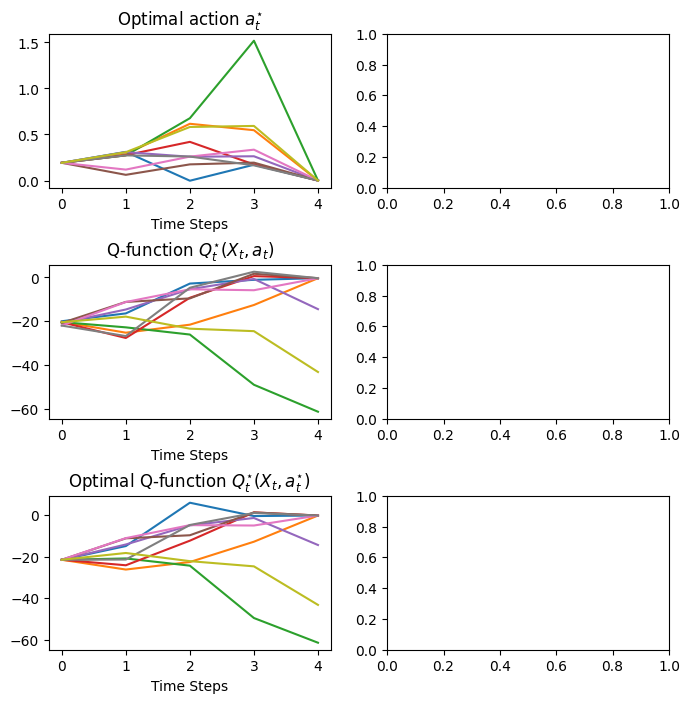

In [643]:
starttime = time.time()

# implied Q-function by input data (using the first form in Eq.(68))
Q_RL = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_RL.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])


# optimal action
a_opt = np.zeros((N_MC,T+1))
a_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_star.iloc[:,-1] = 0


# optimal Q-function with optimal action
Q_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_star.iloc[:,-1] = Q_RL.iloc[:,-1]


max_Q_star = np.zeros((N_MC,T+1))
max_Q_star[:,-1] = Q_RL.iloc[:,-1].values


num_basis = data_mat_t.shape[2]

reg_param = 1e-3
hyper_param =  1e-1

# The backward loop
for t in range(T-1, -1, -1):
    # calculate vector W_t
    S_mat_reg = function_S_vec(t,S_t_mat,reg_param) 
    M_t = function_M_vec(t,Q_star, R, Psi_mat[:,:,t], gamma)

    S_mat_reg = np.array(S_mat_reg, dtype=float)
    M_t = np.array(M_t, dtype=float)
    
    W_t = np.dot(np.linalg.inv(S_mat_reg),M_t)  # this is an 1D array of dimension 3M
    
    # reshape to a matrix W_mat  
    W_mat = W_t.reshape((3, num_basis), order='F')  # shape 3 x M 
        
    # make matrix Phi_mat
    Phi_mat = data_mat_t[t,:,:].T  # dimension M x N_MC

    # compute matrix U_mat of dimension N_MC x 3 
    U_mat = np.dot(W_mat, Phi_mat)
    
    # compute vectors U_W^0,U_W^1,U_W^2 as rows of matrix U_mat  
    U_W_0 = U_mat[0,:]
    U_W_1 = U_mat[1,:]
    U_W_2 = U_mat[2,:]

    # IMPORTANT!!! Instead, use hedges computed as in DP approach:
    # in this way, errors of function approximation do not back-propagate. 
    # This provides a stable solution, unlike
    # the first method that leads to a diverging solution 
    A_mat = function_A_vec(t,delta_S_hat,data_mat_t,reg_param)
    B_vec = function_B_vec(t, Pi_hat)

    # Convert A_mat and B_vec to a NumPy array of floats
    A_mat = np.array(A_mat, dtype=float)
    B_vec = np.array(B_vec, dtype=float)

    phi = np.dot(np.linalg.inv(A_mat), B_vec)
    
    
    a_opt[:,t] = np.dot(data_mat_t[t,:,:],phi)
    a_star.loc[:,t] = a_opt[:,t] 
    
    
    max_Q_star[:,t] = U_W_0 + a_opt[:,t] * U_W_1 + 0.5 * (a_opt[:,t]**2) * U_W_2 
      
    # update dataframes     
    Q_star.loc[:,t] = max_Q_star[:,t]
    
    # update the Q_RL solution given by a dot product of two matrices W_t Psi_t
    Psi_t = Psi_mat[:,:,t].T  # dimension N_MC x 3M  
    Q_RL.loc[:,t] = np.dot(Psi_t, W_t)
    
    
    # trim outliers for Q_RL
    up_percentile_Q_RL =  95 # 95
    low_percentile_Q_RL = 5 # 5
    
    low_perc_Q_RL, up_perc_Q_RL = np.percentile(Q_RL.loc[:,t],[low_percentile_Q_RL,up_percentile_Q_RL])
    
    # trim outliers in values of max_Q_star:
    flag_lower = Q_RL.loc[:,t].values < low_perc_Q_RL
    flag_upper = Q_RL.loc[:,t].values > up_perc_Q_RL
    Q_RL.loc[flag_lower,t] = low_perc_Q_RL
    Q_RL.loc[flag_upper,t] = up_perc_Q_RL
    

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')

f, axarr = plt.subplots(3, 2)
f.subplots_adjust(hspace=.5)
f.set_figheight(8.0)
f.set_figwidth(8.0)

step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
axarr[0, 0].plot(a_star.T.iloc[:, idx_plot]) 
axarr[0, 0].set_xlabel('Time Steps')
axarr[0, 0].set_title(r'Optimal action $a_t^{\star}$')


axarr[1, 0].plot(Q_RL.T.iloc[:, idx_plot]) 
axarr[1, 0].set_xlabel('Time Steps')
axarr[1, 0].set_title(r'Q-function $Q_t^{\star} (X_t, a_t)$')


axarr[2, 0].plot(Q_star.T.iloc[:, idx_plot]) 
axarr[2, 0].set_xlabel('Time Steps')
axarr[2, 0].set_title(r'Optimal Q-function $Q_t^{\star} (X_t, a_t^{\star})$') 


plt.savefig('QLBS_FQI_off_policy_summary_ATM_eta_%d.png' % (100 * eta), dpi=600);

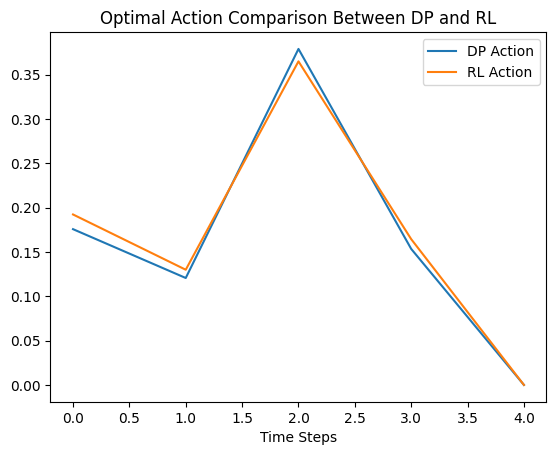

In [644]:
# plot a and a_star
# plot 1 path

num_path =  120

# Note that a from the DP method and a_star from the RL method are now identical by construction
plt.plot(a.T.iloc[:,num_path], label="DP Action")
plt.plot(a_star.T.iloc[:,num_path], label="RL Action")
plt.legend()
plt.xlabel('Time Steps')
plt.title('Optimal Action Comparison Between DP and RL')
plt.show()

In [645]:
# QLBS option price
C_QLBS = - Q_star.copy()
# C_QLBS_1 = - Q_star_1.copy()

print('---------------------------------')
print('       QLBS RL Option Pricing       ')
print('---------------------------------\n')
print('%-25s' % ('Initial Stock Price:'), S0)
print('%-25s' % ('Drift of Stock:'), mu)
print('%-25s' % ('Volatility of Stock:'), sigma)
print('%-25s' % ('Risk-free Rate:'), r)
print('%-25s' % ('Risk aversion parameter :'), risk_lambda)
print('%-25s' % ('Strike:'), K)
print('%-25s' % ('Maturity:'), M)
print('%-26s %.4f' % ('\nThe QLBS Put Price 1 :', (np.mean(C_QLBS.iloc[:,0]))))
# print('%-26s %.4f' % ('\nThe QLBS Put Price 2 :', (np.mean(C_QLBS_1.iloc[:,0]))))


# QLBS_prices = np.array([C_QLBS.iloc[0,0],C_QLBS_1.iloc[0,0]])
QLBS_prices = np.array(C_QLBS.iloc[0,0])

mean_price = np.mean(QLBS_prices)
std_price = np.std(QLBS_prices)

print('%-26s  %.4f +/- %.4f ' % ('QLBS Put Price: ',mean_price,std_price ))
print('%-26s %.4f' % ('\nBlack-Sholes Put Price:', bs_put(0)))
print('\n')

---------------------------------
       QLBS RL Option Pricing       
---------------------------------

Initial Stock Price:      223.8
Drift of Stock:           0.35
Volatility of Stock:      1.44
Risk-free Rate:           0.124
Risk aversion parameter : 0.0008
Strike:                   69.73
Maturity:                 1

The QLBS Put Price 1 :    21.5631
QLBS Put Price:             21.5631 +/- 0.0000 

Black-Sholes Put Price:   14.6243


